In [48]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings

In [49]:
import dowhy
import econml
from dowhy import CausalModel
import dowhy.datasets
import pandas as pd
import numpy as np


dataset = pd.read_csv("ntdb_curated.csv")

# col = ['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1']

# for i in range (1,26):
#     col.append("x"+str(i))
dataset.columns
dataset['OR_visits'] = dataset['OR_visits'].apply(lambda x: True if x >= 1 else False)
print(dataset['OR_visits'])

0       False
1        True
2       False
3       False
4       False
        ...  
6184    False
6185    False
6186    False
6187    False
6188    False
Name: OR_visits, Length: 6189, dtype: bool


In [50]:
dataset.isnull().sum()
#Need to decide whether this is going to be dropped or not depending on MALTS recommendation for data cleaning
# dataset['Survival'] = dataset['EDD_In_Patient']+dataset['EDD_Home']+dataset['EDD_Intensive_Care_Unit']+dataset['EDD_Operating_Room']
# dataset['Death'] = dataset['EDD_Morgue']
# dataset = dataset.drop(['EDD_In_Patient','EDD_Home','EDD_Intensive_Care_Unit','EDD_Operating_Room','EDD_Morgue'],axis=1)
cols = dataset.columns.tolist()
newCols = ['OR_visits', 'DC_to_Morgue']
for i in cols:
    if i != 'OR_visits' and i != 'DC_to_Morgue' and i != 'Unnamed: 0':
        newCols.append(i)
dataset = dataset[newCols]
dataset = dataset.dropna(axis = 'columns')


In [51]:
common_causes=[i for i in dataset]
common_causes = common_causes[2:]
common_causes

['gender',
 'polytrauma',
 'MechOfInjury_0.0',
 'MechOfInjury_Asphyxiation',
 'MechOfInjury_Assault',
 'MechOfInjury_Fall',
 'MechOfInjury_MVC',
 'MechOfInjury_Other',
 'MechOfInjury_Pedestrian',
 'MechOfInjury_Sports',
 'PresentToED',
 'PresentToAmb',
 'PresentToOSH',
 'cm_Not Applicable',
 'cm_Chronic Obstructive Pulmonary Disease (COPD)',
 'cm_Current Smoker',
 'cm_Hypertension',
 'cm_Dementia',
 'cm_Major Psychiatric Illness',
 'cm_Alcohol Use Disorder',
 'cm_Drug Use Disorder',
 'cm_Congenital Anomalies',
 'cm_Congestive Heart Failure (CHF)',
 'cm_Coumadin Therapy',
 'cm_Cerebral Vascular Accident (CVA)',
 'cm_Bleeding Disorder',
 'cm_System Lupus Erythematous',
 'cm_Diabetes Mellitus',
 'cm_Advanced Directive Limiting Care',
 'cm_Obesity',
 'cm_Pre-hospital Cardiac Arrest with Resuscitative Efforts by Healthcare Provider',
 'cm_None',
 'cm_Other',
 'cm_Mulitple Sclerosis',
 'cm_Pre-existing Anemia',
 'cm_History of Peripheral Vascular Disease (PVD)',
 'cm_Cirrhosis',
 'cm_History

In [52]:

# dataset.head
model=CausalModel(
        data = dataset,
        treatment='OR_visits',
        outcome='DC_to_Morgue',
        common_causes=common_causes
        )

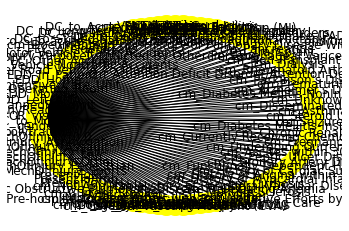

In [53]:
model.view_model()

In [54]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(E[DC_to_Morgue|PresentToED,DC_to_Long-term Acute Care Facility,EDD
d[ORᵥᵢₛᵢₜₛ]                                                                   

                                                                              
_In_Patient,DC_to_Sub-acute rehabilitation facility,cm_Chronic Renal Failure,E
                                                                              

                                                                              
DD_Left_AMA,cm_Pre-hospital Cardiac Arrest with Resuscitative Efforts by Healt
                                                                              

                                                                              
hcare Provider,cm_Current Smoker,cm_Acquired Coagulopathy,cm_Hypertension,cm_C
                                

In [55]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(E[DC_to_Morgue|PresentToED,DC_to_Long-term Acute Care Facility,EDD
d[ORᵥᵢₛᵢₜₛ]                                                                   

                                                                              
_In_Patient,DC_to_Sub-acute rehabilitation facility,cm_Chronic Renal Failure,E
                                                                              

                                                                              
DD_Left_AMA,cm_Pre-hospital Cardiac Arrest with Resuscitative Efforts by Healt
                                                                              

                                                                              
hcare Provider,cm_Current Smoker,cm_Acquired Coagulopathy,cm_Hy

In [56]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance = True)

print(estimate)

print("Causal Estimate is " + str(estimate.value))

data_1 = dataset[dataset["OR_visits"]==1]
data_0 = dataset[dataset["OR_visits"]==0]
print("ATE", np.mean(data_1["DC_to_Morgue"])- np.mean(data_0["DC_to_Morgue"]))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(E[DC_to_Morgue|PresentToED,DC_to_Long-term Acute Care Facility,EDD
d[ORᵥᵢₛᵢₜₛ]                                                                   

                                                                              
_In_Patient,DC_to_Sub-acute rehabilitation facility,cm_Chronic Renal Failure,E
                                                                              

                                                                              
DD_Left_AMA,cm_Pre-hospital Cardiac Arrest with Resuscitative Efforts by Healt
                                                                              

                                                                              
hcare Provider,cm_Current Smoker,cm_Acquired Coagulopathy,cm_Hy

Distance Matching Estimator - doesn't recognise package

In [ ]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

Propensity score stratification

In [ ]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

Propensity score matching

In [25]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["DC_to_Morgue"])- np.mean(data_0["DC_to_Morgue"]))

Causal Estimate is -0.024721279689772176
ATE 0.0013478044043150755


Weighting

In [ ]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

ImportError: Error loading econml.dml.DML. Double-check the method name and ensure that all econml dependencies are installed.

Regression discontinuity - something wrong here (rd_variable name specifically)

In [29]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.15})
# print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

Causal Estimate is None


'iv_instrument_name': 'Z0' needs to be changed to our choice of instrumental variable

In [ ]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Z0'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

In [30]:
refute_results = model.refute_estimate(identified_estimand, estimate, method_name = "random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-0.024721279689772176
New effect:-0.024721279689772176



In [32]:
# 2) EconML double machine learning estimator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
# 1) Linear ITE/CATE estimator (in-built in DoWhy)
df = dataset
#The estimated effect of changing treatment from 0 to 1.
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(E[DC_to_Morgue|PresentToED,DC_to_Long-term Acute Care Facility,EDD
d[ORᵥᵢₛᵢₜₛ]                                                                   

                                                                              
_In_Patient,DC_to_Sub-acute rehabilitation facility,cm_Chronic Renal Failure,E
                                                                              

                                                                              
DD_Left_AMA,cm_Pre-hospital Cardiac Arrest with Resuscitative Efforts by Healt
                                                                              

                                                                              
hcare Provider,cm_Current Smoker,cm_Acquired Coagulopathy,cm_Hy

In [47]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = "ate",  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

ImportError: Error loading econml.dml.DML. Double-check the method name and ensure that all econml dependencies are installed.

In [201]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

NameError: name 'GradientBoostingRegressor' is not defined

In [ ]:
import keras

from econml.deepiv import DeepIVEstimator

dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand,
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1,
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Not needed for our purposes

In [21]:
BETA = 5

data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)

# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"],
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"],
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.797900 -1.524757  1.0  0.133343 -0.971123  0.570611  1.176735   
1    -1.293863  0.240758  0.0  0.176152  0.784583  1.001440  2.175154   
2     0.737523  0.499241  0.0  0.471321  1.701553  0.791216 -0.667507   
3     0.894083 -0.982632  1.0  0.074063  2.465837 -0.503028 -0.458893   
4    -0.605267 -1.631641  1.0  0.927050 -0.782338  0.945847 -0.276427   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.009136 -0.048195  1.0  0.130304  0.400930 -0.116123  0.610205   
9996  0.407634 -1.070540  1.0  0.034995  0.972761 -0.011319 -0.712027   
9997  1.189302 -0.226554  1.0  0.262504  1.437425  0.899275  2.058467   
9998 -2.442810 -0.850211  0.0  0.694285  0.641811  1.354751  0.588460   
9999  1.473420  0.403831  1.0  0.674738  0.865393  0.849021  1.226882   

            W3  v0  y  
0     1.377399   1  1  
1     2.731591   1  1  
2     0.322772   1  1  
3    -0.943244   1  1  
4  

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary,
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

Initial code for DBSCAN Clustering Algorithm

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

#This code will have to be adjusted for the new data

# # #############################################################################
# # Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(
#     n_samples=750, centers=centers, cluster_std=0.4, random_state=0
# )

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()